
# A CNN on Intel Image Classification dataset

I created a convolutional neural network and after training it on the Image dataset provided by Intel. I tried to build a model using all the data, and I got 77 accuracy score. However there are two classes in the data called "buildings" and "stree" that have a lot in common and in some cases, it's hard even for me to say which is which. This comes from the fact that most streets also contain buildings.
Just to see how good the model performs without this problem, I omitted the "street" category and the results improved by 6 percent.

This model is far from complete and in my next step I will try to find a solution so that the model can distinguish between the above discussed categories.



**Data available at [kaggle](https://www.kaggle.com/puneet6060/intel-image-classification/download)**


P.S. 
The same problem goes between images containing sky, and the "sea" category, and a few more of these.


# Second Part: VGG16: Details
At my second attempt, I tried VGG16 on the whole dataset. The results are explained in the related section.


In [0]:
import numpy as np
import os
import sys
import cv2
import tensorflow as tf
from tqdm import tqdm

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from glob import glob

In [0]:
from sklearn.metrics import confusion_matrix
from collections import Counter

In [6]:
!wget "https://storage.googleapis.com/kaggle-data-sets/111880%2F269359%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1591690073&Signature=RjNS2bP5wE8iltfxPyIBMhOaXsBWWzcwSmJ2YvvVyWJ%2BPwwPWWqpOWm25EmrMNAze0ZdIYLQDUdNd%2BwX0CrENKZazBxEIgYBAv8au7ewFRh80%2BbDXmhivJovzEYhg96FGyBmm8Orzb%2FTf%2BUSEnEM7IdQZTzqfxCiDtZiPOlQu5nbLKPpnFMlocV2vedRvBMVK63bUekSJ8%2BXSP3HEM8a6MNILKStxrk0uo0i1EojDUzkhpDAtwGOeWeirUWjRmMsbF28T9ylukQ5QnJz7AgUOLJJXdApbnJaXiB3h0go%2BfLAomJ8xQ393E7zFc%2BtyCrGnCkrppcVGuATAw5qtyebCw%3D%3D"

The name is too long, 482 chars total.
Trying to shorten...
New name is 111880%2F269359%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1591690073&Signature=RjNS2bP5wE8iltfxPyIBMhOaXsBWWzcwSmJ2YvvVyWJ+PwwPWWqpOWm25EmrMNAze0ZdIYLQDUdNd+wX0CrENKZazBxEIgYBAv8a.
--2020-06-09 06:14:31--  https://storage.googleapis.com/kaggle-data-sets/111880%2F269359%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1591690073&Signature=RjNS2bP5wE8iltfxPyIBMhOaXsBWWzcwSmJ2YvvVyWJ%2BPwwPWWqpOWm25EmrMNAze0ZdIYLQDUdNd%2BwX0CrENKZazBxEIgYBAv8au7ewFRh80%2BbDXmhivJovzEYhg96FGyBmm8Orzb%2FTf%2BUSEnEM7IdQZTzqfxCiDtZiPOlQu5nbLKPpnFMlocV2vedRvBMVK63bUekSJ8%2BXSP3HEM8a6MNILKStxrk0uo0i1EojDUzkhpDAtwGOeWeirUWjRmMsbF28T9ylukQ5QnJz7AgUOLJJXdApbnJaXiB3h0go%2BfLAomJ8xQ393E7zFc%2BtyCrGnCkrppcVGuATAw5qtyebCw%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 2607:f8b0:400c:c07::80
Connecting to s

In [7]:
!unzip iic.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating: seg_train/seg_train/mountain/7695.jp

# A glance on the data

In [0]:
img = mpimg.imread("seg_train/seg_train/forest/10007.jpg")

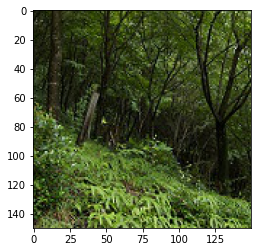

In [0]:
plt.imshow(img)

# Loading the data from the downloaded file
note:
I tried to build a model using all the data, and I got 77 accuracy score. There are two classes in the data called "buildings" and "stree" that have a lot in common and in some cases, it's hard even for me to say which is which :)

Just to see how good the model performs without this problem, I omitted the "street" category and the results improved by 6 percent.

In [0]:
classes = "mountain street glacier buildings sea forest".split(" ") 
class_labels = {class_name:i for i, class_name in enumerate(classes)}

In [0]:
K = len(classes)
image_size = (150, 150)

In [0]:
# this code is borrowed. I unfortunately don't remember from whom. :(
# message me if it's yours to get the credit.
def load_data():
  datasets = ["/content/seg_train/seg_train", "/content/seg_test/seg_test"]
  output = []

  for dataset in datasets:
    images = []
    labels = []

    print(f"loading {dataset}")

    for folder in os.listdir(dataset):
      label = class_labels[folder]

      #tqdm is just to produce a progress bar, not essential.
      for file in tqdm(os.listdir(os.path.join(dataset, folder))):
        img_path = os.path.join(os.path.join(dataset, folder), file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)
        
        images.append(image)
        labels.append(label)
    
    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")

    output.append((images, labels))
  
  return output

In [11]:
(X_train, y_train), (X_test, y_test) = load_data()

  4%|▎         | 85/2274 [00:00<00:02, 847.85it/s]

loading /content/seg_train/seg_train


 36%|███▌      | 183/510 [00:00<00:00, 1823.40it/s]

loading /content/seg_test/seg_test


100%|██████████| 474/474 [00:00<00:00, 1444.18it/s]


In [0]:
input_shape = X_train[0].shape

In [0]:
# to normalize:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [0]:
model = Sequential([
  Input(shape=input_shape),
  Conv2D(32, (3,3), activation="relu", padding="same"),
  MaxPooling2D((2,2), padding="same"),
  Conv2D(64, (3,3), activation="relu", padding="same"),
  MaxPooling2D((2,2), padding="same"),
  Conv2D(128, (3,3), activation="relu", padding="same"),
  MaxPooling2D((2,2), padding="same"),

  Flatten(),

  Dense(64, activation="relu"),
  Dropout(0.15),
  Dense(128, activation="relu"),
  Dropout(0.15),
  Dense(128, activation="relu"),
  
  Dense(K, activation="softmax")                  
])

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 38, 38, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 19, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 46208)             0

In [0]:
model.fit(X_train, y_train, batch_size=30, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
389/389 [==============================] - 516s 1s/step - loss: 0.9997 - accuracy: 0.5877 - val_loss: 0.8061 - val_accuracy: 0.6467
Epoch 2/30
389/389 [==============================] - 513s 1s/step - loss: 0.7181 - accuracy: 0.7209 - val_loss: 0.6012 - val_accuracy: 0.7863
Epoch 3/30
389/389 [==============================] - 504s 1s/step - loss: 0.5380 - accuracy: 0.8042 - val_loss: 0.5436 - val_accuracy: 0.8059
Epoch 4/30
389/389 [==============================] - 502s 1s/step - loss: 0.4250 - accuracy: 0.8520 - val_loss: 0.4499 - val_accuracy: 0.8511
Epoch 5/30
389/389 [==============================] - 509s 1s/step - loss: 0.3418 - accuracy: 0.8796 - val_loss: 0.4878 - val_accuracy: 0.8391
Epoch 6/30
389/389 [==============================] - 514s 1s/step - loss: 0.2715 - accuracy: 0.9049 - val_loss: 0.4811 - val_accuracy: 0.8523
Epoch 7/30
389/389 [==============================] - 519s 1s/step - loss: 0.2306 - accuracy: 0.9229 - val_loss: 0.5733 - val_accuracy: 0.8383

In [0]:
preds = np.argmax(model.predict(X_test), axis=-1)

array([ True,  True,  True, ...,  True,  True,  True])

In [0]:
mistakes = [(i,j) for i, j in zip(y_test, preds) if i != j]
common_mistakes = Counter(mistakes).most_common(10)

In [0]:
label_to_name = {}
for i, j in class_labels.items():
  label_to_name[j] = i

In [0]:
for mistake, count in common_mistakes:
  print(f"True label: {label_to_name[mistake[0]]}\t, Predicted: {label_to_name[mistake[1]]}\t, Count: {count}")

True label: glacier	, Predicted: mountain	, Count: 87
True label: mountain	, Predicted: glacier	, Count: 69
True label: sea	, Predicted: mountain	, Count: 44
True label: glacier	, Predicted: sea	, Count: 41
True label: sea	, Predicted: glacier	, Count: 41
True label: mountain	, Predicted: sea	, Count: 33
True label: mountain	, Predicted: buildings	, Count: 17
True label: sea	, Predicted: buildings	, Count: 16
True label: buildings	, Predicted: sea	, Count: 15
True label: buildings	, Predicted: forest	, Count: 14


# Pre-trained models
Due to lack of high-performance hardware, I tried to use pre-trained models instead of designing and training my own model. I used the VGG16 model provided by Tensorflow and used the weights for the ImageNet dataset. 

It is noteworthy that in this try, model was trained for 5 epochs, with a batch_size of 32 (Default). In result, the model used only 2195 data samples (out of 14k). I conjecture that training the model to go over every available data instance for at least once, would probably improve the results. 

There was a significant improvements on the results. The model reach 86 percent accuracy. 

In [0]:
image_size = list(image_size)


In [15]:
vgg = VGG16(
    input_shape= image_size + [3],
    weights="imagenet",
    include_top=False
)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
vgg.trainable = False

In [0]:
x = Flatten()(vgg.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(128, activation="relu")(x)
x = Dense(K, activation="softmax")(x)

In [0]:
model = Model(inputs=vgg.input, outputs=x)

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [0]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [25]:
r = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
439/439 [==============================] - 3592s 8s/step - loss: 0.5128 - accuracy: 0.8068 - val_loss: 0.3493 - val_accuracy: 0.8713
Epoch 2/5
439/439 [==============================] - 3605s 8s/step - loss: 0.3403 - accuracy: 0.8776 - val_loss: 0.3742 - val_accuracy: 0.8577
Epoch 3/5
439/439 [==============================] - 3610s 8s/step - loss: 0.2861 - accuracy: 0.8954 - val_loss: 0.3242 - val_accuracy: 0.8797
Epoch 4/5
439/439 [==============================] - 3611s 8s/step - loss: 0.2495 - accuracy: 0.9077 - val_loss: 0.3487 - val_accuracy: 0.8793
Epoch 5/5
439/439 [==============================] - 3621s 8s/step - loss: 0.2091 - accuracy: 0.9237 - val_loss: 0.3868 - val_accuracy: 0.8693


In [0]:
model.save("vgg16.h5")

In [0]:
preds = np.argmax(model.predict(X_test), axis=-1)

In [0]:
mistakes = [(i,j) for i, j in zip(y_test, preds) if i != j]
common_mistakes = Counter(mistakes).most_common(10)

In [0]:
label_to_name = {}
for i, j in class_labels.items():
  label_to_name[j] = i

In [30]:
for mistake, count in common_mistakes:
  print(f"True label: {label_to_name[mistake[0]]}\t, Predicted: {label_to_name[mistake[1]]}\t, Count: {count}")

True label: buildings	, Predicted: street	, Count: 95
True label: glacier	, Predicted: mountain	, Count: 86
True label: mountain	, Predicted: glacier	, Count: 53
True label: glacier	, Predicted: sea	, Count: 37
True label: mountain	, Predicted: sea	, Count: 31
True label: sea	, Predicted: mountain	, Count: 17
True label: sea	, Predicted: glacier	, Count: 12
True label: sea	, Predicted: street	, Count: 6
True label: buildings	, Predicted: sea	, Count: 6
True label: street	, Predicted: buildings	, Count: 6
